# Figure Generation for Manuscript

This notebook explores annotation of the high-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014) as a validation attempt.  
SAFE did not return significant results on this dataset (P < 0.01), so only the RISK analysis is shown as **Supplementary Figure S7**.

---

## Supplementary Figure S7: RISK Analysis of Citation Network
- Citation network of 20,147 nodes and 331,044 edges
- ForceAtlas2 layout used for visualization
- SAFE clusters detected with SAFE's shortest-path algorithm
- No significant clusters or annotations detected

---

### Workflow
- **Input:** High-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014)  
- **Tools:** Python, RISK, NetworkX, ForceAtlas2, Matplotlib
- **Output:** No significant SAFE annotations; no figure saved

In [1]:
# First, extract snippets from article abstracts and determine their subfield(s)

import gzip
import pickle
import requests
import tarfile
import io
import re
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import defaultdict


# Enhanced function to extract the journal reference from the abstract content
def extract_journal_ref(text, citation):
    """
    Extract journal references from text and map them to the given citation.
    """
    journals = defaultdict(list)
    # Updated pattern to capture journal names, including multi-word names with spaces and periods
    journal_pattern = r"Journal-ref:\s*([A-Za-z0-9\.\s\-]+)"

    # Search for the Journal-ref field
    journal_match = re.search(journal_pattern, text)
    if journal_match:
        # Extract the full journal reference string
        journal_ref = journal_match.group(1).strip()

        # Extract only words ending with a period, conjoining them into a single key
        words_with_periods = re.findall(r"[A-Za-z]+\.", journal_ref)
        # Don't add single period abbr
        if words_with_periods and len(words_with_periods) > 1:
            # Join the words, remove spaces, and create a compact key
            journal_name = "".join(words_with_periods).strip()
            journals[journal_name].append(citation)

    return journals


# The dictionary of subfields with their respective keywords
subfield_keywords = {
    "String Theory": ["string", "brane", "superstring", "m-theory", "tachyon", "compact", "calabi"],
    "General Relativity": [
        "gravit",
        "spacetime",
        "horizon",
        "einstein",
        "schwarzschild",
        "geodesic",
    ],
    "Cosmology": [
        "cosmo",
        "inflation",
        "dark matter",
        "dark energy",
        "big bang",
        "multiverse",
        "redshift",
    ],
    "Quantum Mechanics": [
        "quant",
        "wavefunc",
        "superposit",
        "entangle",
        "decoher",
        "tunnel",
        "uncert",
    ],
    "Quantum Field Theory": [
        "gaug",
        "lagrang",
        "renormal",
        "symmetry",
        "feynman",
        "fermion",
        "boson",
    ],
    "Condensed Matter Physics": [
        "supercond",
        "bandgap",
        "quasipart",
        "phonon",
        "topolog",
        "fermi",
        "insulat",
    ],
    "Particle Physics": ["quark", "lepton", "gluon", "colli", "neutrino", "higgs", "hadron"],
    "Nuclear Physics": ["fus", "fission", "nucleon", "deuteron", "isotope", "heavy ion", "neutron"],
}


# Check if any of the subfield-specific keywords appear in the text
def find_subfield_matches_in_text(subfield_keywords, text, citation):
    matches = defaultdict(list)
    for subfield, keywords in subfield_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                matches[subfield].append(citation)
                break
    return matches


# Process an abstract based on mode (either 'subfield_citations' or 'journal')
def process_abstract(file_content, citation, mode="subfield_citations"):
    if mode == "subfield_citations":
        return find_subfield_matches_in_text(subfield_keywords, file_content, citation)
    elif mode == "journal":
        return extract_journal_ref(file_content, citation)


# Stream and process the tar.gz file for abstracts based on mode
def stream_and_process_tar_gz(url, mode="subfield_citations"):
    response = requests.get(url, stream=True)
    result_map = defaultdict(list)

    if response.status_code == 200:
        file_like_object = io.BytesIO(response.raw.read())
        with tarfile.open(fileobj=file_like_object, mode="r:gz") as tar:
            for member in tar.getmembers():
                if member.isfile() and member.name.endswith(".abs"):
                    citation = member.name.split("/")[-1].replace(".abs", "")
                    file_content = tar.extractfile(member).read().decode("utf-8")

                    # Process abstract based on the specified mode
                    processed_data = process_abstract(file_content, citation, mode)

                    # Update result_map with processed data
                    for key, citations in processed_data.items():
                        result_map[key].extend(citations)

    return result_map


# URL for the abstracts (cit-HepTh)
abstracts_url = "https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz"

# Process the abstracts and aggregate citations by subfield
subfield_citations_map = stream_and_process_tar_gz(abstracts_url)

# # Output the mapping of subfields to citations
# for subfield, citations in subfield_citations_map.items():
#     print(f"{subfield}: {citations}")

In [42]:
# Convert `subfield_citations_map` into a text format that's compatible with SAFE

import os
import tarfile


def build_attributes_tar_file_from_dict(d, export_path):
    """
    Build an attributes tar.gz file from a dictionary mapping terms -> citation lists.
    """
    # Collect unique citations across all terms
    citations = sorted(set(citation for citation_list in d.values() for citation in citation_list))

    # Build header and rows
    header = ["citation"] + list(d.keys())
    rows = []
    for citation in citations:
        row = [citation]
        for term, citation_list in d.items():
            row.append("1" if citation in citation_list else "0")
        rows.append(row)

    # Write output text file
    output_file = "output_file.txt"
    with open(output_file, "w") as file:
        file.write("\t".join(header) + "\n")
        for row in rows:
            file.write("\t".join(row) + "\n")

    # Tar and gzip the file
    with tarfile.open(export_path, "w:gz") as tar:
        tar.add(output_file)

    # Cleanup
    os.remove(output_file)


build_attributes_tar_file_from_dict(
    subfield_citations_map, "./data/tar.gz/annotations/subfield_citations_map.tar.gz"
)

In [3]:
# First, load the high-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014)

import json
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


def read_gpickle(filepath):
    with open(filepath, "rb") as f:
        G = pickle.load(f)
    return G


def write_gpickle(graph, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(graph, f)


# Load, relabel, and add SAFE attributes in one step
costanzo_network_path = "./data/gpickle/20250117_high_energy_physics_citations.gpickle"
G = read_gpickle(costanzo_network_path)

# Relabel nodes to 0..N-1
mapping = {old: i for i, old in enumerate(sorted(G.nodes(), key=str))}
G_relabelled = nx.relabel_nodes(G, mapping)

# Add required SAFE attributes
for n in G_relabelled.nodes():
    G_relabelled.nodes[n]["label_orf"] = str(n)
    G_relabelled.nodes[n]["label"] = str(n)
    G_relabelled.nodes[n]["key"] = str(n)

# Keep original ID for back-mapping
original_id_map = {mapping[old]: old for old in mapping}
nx.set_node_attributes(G_relabelled, original_id_map, "original_id")

# Save network as GPickle
write_gpickle(G_relabelled, "./data/gpickle/20250117_high_energy_physics_citations.gpickle")

print(
    f"Relabelled network saved with {len(G_relabelled.nodes())} nodes and required SAFE attributes."
)

Relabelled network saved with 20147 nodes and required SAFE attributes.


## Find Physics Subfield Regions in Network using SAFE

### NOTE: Begin analysis here if you already have a satisfactory GPickle file of the citation network above.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import json


from safepy import safe

%matplotlib inline

In [5]:
# Parameters

path_to_safe_data = "./"  # path to the cloned safe-data repository (https://github.com/baryshnikova-lab/safe-data.git)

In [6]:
# Initialize the safe object

sf_ppi = safe.SAFE()

In [7]:
# Load Cytoscape session file

sf_ppi.load_network(
    network_file="./data/gpickle/20250117_high_energy_physics_citations.gpickle",
)

Loading network from ./data/gpickle/20250117_high_energy_physics_citations.gpickle


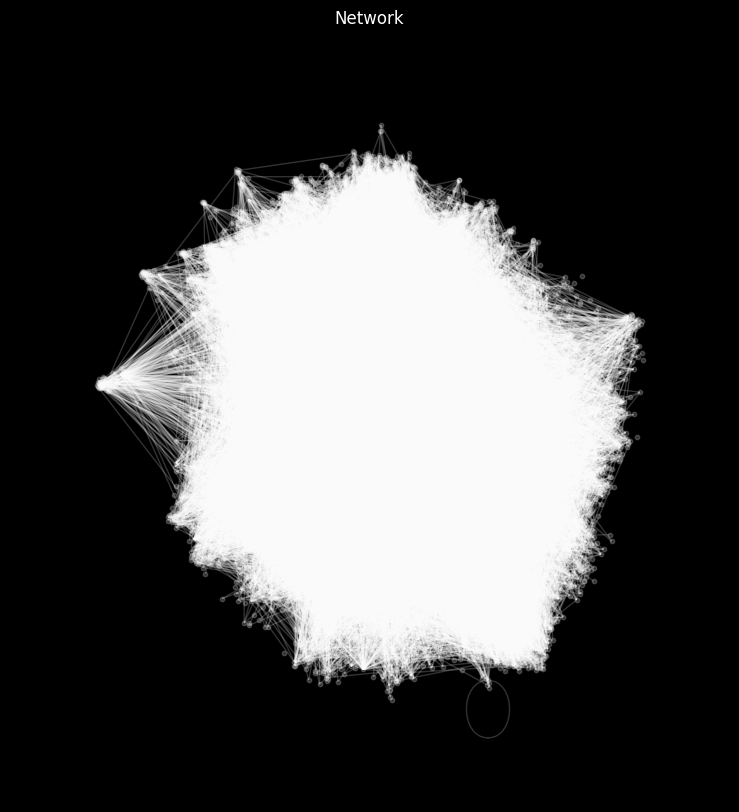

In [8]:
# View network as exported by Cytoscape

sf_ppi.plot_network()
plt.show()

In [9]:
# Now load the attributes...

sf_ppi.load_attributes(attribute_file="./data/tar.gz/annotations/subfield_citations_map.tar.gz")

Loading attributes from ./data/tar.gz/annotations/subfield_citations_map.tar.gz


In [46]:
import time

neighborhood_start_time = time.time()

# Explicitly define the node_distance metric and the neighborhood radius
sf_ppi.define_neighborhoods(
    node_distance_metric="shortpath_weighted_layout", neighborhood_radius=0.1
)

neighborhood_end_time = time.time()
neighborhood_elapsed = neighborhood_end_time - neighborhood_start_time
print(f"Neighborhood definition completed in {neighborhood_elapsed:.2f} seconds.")

Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.10 x diameter
Number of nodes per neighborhood (mean +/- std): 20147.00 +/- 0.00
Neighborhood definition completed in 6384.79 seconds.


In [47]:
pvalues_start_time = time.time()

# Compute statistical significance of the neighborhoods
sf_ppi.enrichment_type = "permutation"
sf_ppi.enrichment_threshold = 0.001
sf_ppi.compute_pvalues(processes=6, num_permutations=1_000)

pvalues_end_time = time.time()
pvalues_elapsed = pvalues_end_time - pvalues_start_time
print(f"Permutation test completed in {pvalues_elapsed:.2f} seconds.")

Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=6
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 167/167 [04:52<00:00,  1.75s/it]







Permutation test completed in 361.00 seconds.


In [48]:
# Define top attributes

sf_ppi.define_top_attributes()

Criteria for top attributes:
- minimum number of enriched neighborhoods: 10
- region-specific distribution of enriched neighborhoods as defined by: connectivity
Number of top attributes: 0


In [51]:
# Determine clustering threshold and trim domains

sf_ppi.define_domains(attribute_distance_threshold=0.001)
sf_ppi.trim_domains()

ValueError: The number of observations cannot be determined on an empty distance matrix.

In [2]:
# Plot network

sf_ppi.plot_composite_network(show_each_domain=False, show_domain_ids=False, labels=[])

# Save the figure
# plt.savefig('./png/supp_fig_2c.png', facecolor="black", dpi=350)